In [1]:
from skimage.io import imread
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
from instapipeline import QuantiusAnnotation, SpotAnnotationAnalysis, autocrop, clus, param, util, vis

### Parameters

In [2]:
clustering_params = ['AffinityPropagation', -350]
declumping_params = ['KMeans', 2]

background_list = ['cells']
nspots_list = [50, 100, 150]
spot_sig = 1.75
snr_list = [5, 10, 15, 20]

### Get clusters pre and post QC

In [3]:
clusters_pre_and_post_qc = []
for background in background_list:
    json_filename = 'SynthData_cells.json' if background == 'cells' else 'SynthTests_tissue.json'
    json_filepath = './datasets/SynthTest/%s' % json_filename
    prefix = 'MAX_C3-ISP_300_1_' if background == 'cells' else 'MAX_ISP_300_1_'
    
    for nspots in nspots_list:
        for snr in snr_list:
            
            if snr == 15:
                json_filename = 'snr15_%s.json' % nspots
                json_filepath = './datasets/SynthTest/%s' % json_filename
            
            else:
                json_filename = 'SynthData_cells.json' if background == 'cells' else 'SynthTests_tissue.json'
                json_filepath = './datasets/SynthTest/%s' % json_filename
            
            # read annotations
            name = '%snspots%s_spot_sig%s_snr%s_2.5' % (prefix, nspots, spot_sig, snr)
            img_filename = '%s_spot_img.png' % (name)
            csv_filename = '%s_coord_snr_list.csv' % (name)
            img_filepath = './datasets/SynthTest/spot_images/%s/%s' % (background, img_filename)
            csv_filepath = './datasets/SynthTest/spot_data/%s/%s' % (background, csv_filename)
                        
            qa = QuantiusAnnotation(json_filepath, img_filename)
            sa = SpotAnnotationAnalysis(qa)
            anno_all = qa.df()
            
            # cluster annotations
            clusters_pre_qc = sa.get_clusters(anno_all, clustering_params)            

            # apply QC
            cluster_size_threshold = clus.get_cluster_size_threshold(clusters_pre_qc)
            small_clusters, large_clusters = clus.sort_clusters_by_size(clusters_pre_qc, cluster_size_threshold)
        
            clumpiness_threshold = clus.get_clumpiness_threshold(large_clusters)
            clumpy_clusters, nonclumpy_clusters = clus.sort_clusters_by_clumpiness(large_clusters, clumpiness_threshold)
            clusters_post_qc = nonclumpy_clusters
            
            if len(clumpy_clusters.index) is not 0:
                for i in range(len(clumpy_clusters.index)):
                    subclusters = clus.declump(clumpy_clusters, i, declumping_params)
                clusters_post_qc = pd.concat([subclusters, clusters_post_qc], ignore_index=True)
            
            clusters_pre_and_post_qc.append((img_filename, img_filepath, csv_filename, csv_filepath, clusters_pre_qc, clusters_post_qc))
            

### Save consensus centroids

In [8]:
if not os.path.exists('datasets/SynthTest/clusters'):
    os.mkdir('datasets/SynthTest/clusters')
if not os.path.exists('datasets/SynthTest/clusters/pre_qc'):
    os.mkdir('datasets/SynthTest/clusters/pre_qc')
if not os.path.exists('datasets/SynthTest/clusters/post_qc'):
    os.mkdir('datasets/SynthTest/clusters/post_qc')

In [9]:
for img_filename, img_filepath, csv_filename, csv_filepath, clusters_pre_qc, clusters_post_qc in clusters_pre_and_post_qc:
    im = imread(img_filepath)
    img_height = len(im)
    
    clusters_pre_qc_list = []
    for index in clusters_pre_qc.index:
        row = clusters_pre_qc.iloc[index]
        x, y = row['centroid_x'], row['centroid_y']
        clusters_pre_qc_list.append([x, img_height-y])
    path = 'datasets/SynthTest/clusters/pre_qc/%s' % (csv_filename)
    np.savetxt(path, np.asarray(clusters_pre_qc_list), delimiter=",", comments='', header='centroid_x,centroid_y')

    clusters_post_qc_list = []
    for index in clusters_post_qc.index:
        row = clusters_post_qc.iloc[index]
        x, y = row['centroid_x'], row['centroid_y']
        clusters_post_qc_list.append([x, img_height-y])
    path = 'datasets/SynthTest/clusters/post_qc/%s' % (csv_filename)
    np.savetxt(path, np.asarray(clusters_post_qc_list), delimiter=",", comments='', header='centroid_x,centroid_y')
    

### Calculate precision and recall: consensus annotations vs. reference annotations

In [10]:
correctness_threshold = 4

In [13]:
sort_list, precision_list, recall_list = [], [], []
for csv_filename in os.listdir('./datasets/SynthTest/clusters/pre_qc'):
    
    consensus_filepaths = ['./datasets/SynthTest/clusters/pre_qc/%s' % csv_filename,
                           './datasets/SynthTest/clusters/post_qc/%s' % csv_filename]
    for consensus_filepath in consensus_filepaths:
    
        consensus_coords = np.asarray(pd.read_csv(consensus_filepath))
        consensus_kdt = KDTree(consensus_coords, leaf_size=2, metric='euclidean')

        if csv_filename.startswith('MAX_ISP'):
            reference_filepath = './datasets/SynthTest/spot_data/tissue/%s' % csv_filename
        else:
            reference_filepath = './datasets/SynthTest/spot_data/cells/%s' % csv_filename
        reference_coords = np.asarray(pd.read_csv(reference_filepath))[:,:2]
        reference_kdt = KDTree(reference_coords, leaf_size=2, metric='euclidean')

        correct_consensus = []
        incorrect_consensus = []
        detected_reference = []
        undetected_reference = []

        # correct vs. incorrect

        for consensus_coord in consensus_coords:
            dist, ind = reference_kdt.query([consensus_coord], k=1)
            if dist[0][0] < correctness_threshold:
                correct_consensus.append(consensus_coord)
            else:
                incorrect_consensus.append(consensus_coord)

        # detected vs. undetected

        for reference_coord in reference_coords:
            dist, ind = consensus_kdt.query([reference_coord], k=1)
            if dist[0][0] < correctness_threshold:
                detected_reference.append(reference_coord)
            else:
                undetected_reference.append(reference_coord)
        
        np.savetxt(consensus_filepath.replace('.csv','_correct_consensus.csv'), np.asarray(correct_consensus), delimiter=",", comments='', header='centroid_x,centroid_y')
        np.savetxt(consensus_filepath.replace('.csv','_incorrect_consensus.csv'), np.asarray(incorrect_consensus), delimiter=",", comments='', header='centroid_x,centroid_y')
        np.savetxt(consensus_filepath.replace('.csv','_detected_reference.csv'), np.asarray(detected_reference), delimiter=",", comments='', header='centroid_x,centroid_y')
        np.savetxt(consensus_filepath.replace('.csv','_undetected_reference.csv'), np.asarray(undetected_reference), delimiter=",", comments='', header='centroid_x,centroid_y')
        

For each image, calculate and save
- precision
- recall
- mean snr
- mean nnd

In [12]:
# for each image
for csv_filename in os.listdir('./datasets/SynthTest/clusters/pre_qc':
    
    if csv_filename.endswith('_coord_snr_list.csv'):
        consensus_filepaths = ['./datasets/SynthTest/clusters/pre_qc/%s' % csv_filename,
                               './datasets/SynthTest/clusters/post_qc/%s' % csv_filename]

        # pre-qc and post-qc data
        for consensus_filepath in consensus_filepaths:

            prec_rec_snr_nnd_list = []
            correct_consensus_path = consensus_filepath.replace('.csv','_correct_consensus.csv')
            incorrect_consensus_path = consensus_filepath.replace('.csv','_incorrect_consensus.csv')
            detected_reference_path = consensus_filepath.replace('.csv','_detected_reference.csv')
            undetected_reference_path = consensus_filepath.replace('.csv','_undetected_reference.csv')

            prec_rec_snr_nnd_path = consensus_filepath.replace('.csv','_prec_rec_snr_nnd.csv')

            num_correct = len(np.asarray(pd.read_csv(correct_consensus_path)))
            num_incorrect = len(np.asarray(pd.read_csv(incorrect_consensus_path)))
            num_detected = len(np.asarray(pd.read_csv(detected_reference_path)))
            num_undetected = len(np.asarray(pd.read_csv(undetected_reference_path)))

            precision = num_correct / (num_correct + num_incorrect)
            recall = num_detected / (num_detected + num_undetected)

            # from filename, get mean snr and reference filepath
            if csv_filename.startswith('MAX_ISP'):
                identity = csv_filename.split('MAX_ISP_300_1_')[1]
                mean_snr = int(identity.split('_')[3].split('snr')[1])
                reference_filepath = './datasets/SynthTest/spot_data/tissue/%s' % csv_filename
            else:
                mean_snr = int(csv_filename.split('MAX_C3-ISP_300_1_')[1].split('_')[3].split('snr')[1])
                reference_filepath = './datasets/SynthTest/spot_data/cells/%s' % csv_filename
            
            # get mean_nnd
            reference_coords = np.asarray(pd.read_csv(reference_filepath))[:,:2]
            reference_kdt = KDTree(reference_coords, leaf_size=2, metric='euclidean')
            nnd_list = []
            for reference_coord in reference_coords:
                dist, ind = reference_kdt.query([reference_coord], k=2)
                nnd_list.append(dist[0][1])
            mean_nnd = np.mean(nnd_list)
            
            prec_rec_snr_nnd_list.append([precision, recall, mean_snr, mean_nnd])
            np.savetxt(prec_rec_snr_nnd_path, np.asarray(prec_rec_snr_nnd_list), delimiter=",", comments='', header='precision,recall,snr,nnd')
            

## Plot precision and recall before and after QC steps

- QC step 1: thresholding clusters by number of annotations
- QC step 2: declumping

In [3]:
cm = 'plasma'


--------------
Cell Background
--------------


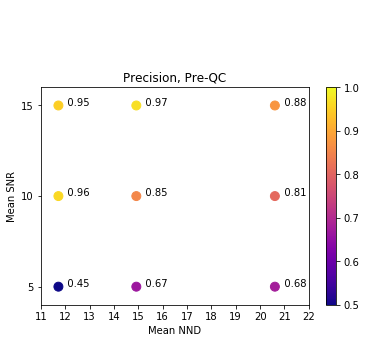

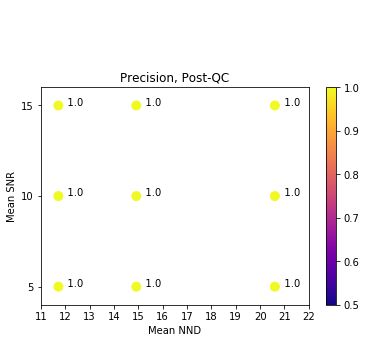

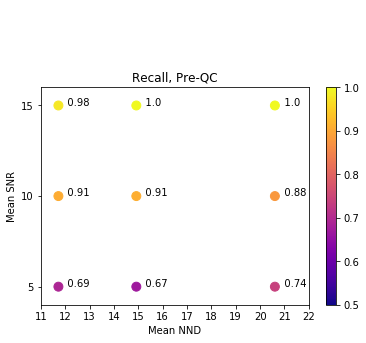

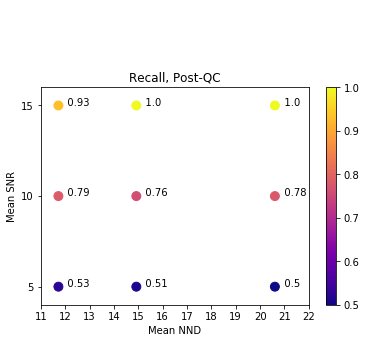

mean_precision_pre_qc_snr5 = 0.6
mean_precision_post_qc_snr5 = 1.0
mean_precision_delta_snr5 = 0.4

mean_recall_pre_qc_snr5 = 0.7
mean_recall_post_qc_snr5 = 0.51
mean_recall_delta_snr5 = -0.19

mean_precision_pre_qc_snr10 = 0.87
mean_precision_post_qc_snr10 = 1.0
mean_precision_delta_snr10 = 0.13

mean_recall_pre_qc_snr10 = 0.9
mean_recall_post_qc_snr10 = 0.78
mean_recall_delta_snr10 = -0.12

mean_precision_pre_qc_snr15 = 0.93
mean_precision_post_qc_snr15 = 1.0
mean_precision_delta_snr15 = 0.07

mean_recall_pre_qc_snr15 = 0.99
mean_recall_post_qc_snr15 = 0.98
mean_recall_delta_snr15 = -0.02



In [4]:
prefixes = ['MAX_C3-ISP']

# cell plots, then tissue plots
for prefix in prefixes:
    
    precision_pre_qc_list_snr5, precision_post_qc_list_snr5, recall_pre_qc_list_snr5, recall_post_qc_list_snr5 = [], [], [], []
    precision_pre_qc_list_snr15, precision_post_qc_list_snr15, recall_pre_qc_list_snr15, recall_post_qc_list_snr15 = [], [], [], []
    precision_pre_qc_list_snr10, precision_post_qc_list_snr10, recall_pre_qc_list_snr10, recall_post_qc_list_snr10 = [], [], [], []

    background = 'Cell' if prefix == 'MAX_C3-ISP' else 'Tissue'
    print('\n--------------\n%s Background\n--------------' % (background))
    
    for precision_or_recall in ['Precision', 'Recall']:
        for pre_or_post in ['pre_qc', 'post_qc']:

            # for each image
            mean_nnd_list, mean_snr_list, data_list = [], [], []
            for csv_filename in os.listdir('./datasets/SynthTest/clusters/%s' % pre_or_post):

                if csv_filename.startswith(prefix) and csv_filename.endswith('_coord_snr_list.csv'):

                    path = './datasets/SynthTest/clusters/%s/%s' % (pre_or_post, csv_filename)
                    prec_rec_snr_nnd_path = path.replace('.csv','_prec_rec_snr_nnd.csv')

                    precision, recall, mean_snr, mean_nnd = np.asarray(pd.read_csv(prec_rec_snr_nnd_path))[0]
                    mean_nnd_list.append(mean_nnd)
                    mean_snr_list.append(mean_snr)
                    data = precision if precision_or_recall == 'Precision' else recall
                    
                    data_list.append(data)
            
                    if 'snr5' in csv_filename:
                        if precision_or_recall == 'Precision' and pre_or_post == 'pre_qc':
                            precision_pre_qc_list_snr5.append(data)
                        elif precision_or_recall == 'Precision' and pre_or_post == 'post_qc':
                            precision_post_qc_list_snr5.append(data)
                        elif precision_or_recall == 'Recall' and pre_or_post == 'pre_qc':
                            recall_pre_qc_list_snr5.append(data)
                        elif precision_or_recall == 'Recall' and pre_or_post == 'post_qc':
                            recall_post_qc_list_snr5.append(data)
                    elif 'snr10' in csv_filename:
                        if precision_or_recall == 'Precision' and pre_or_post == 'pre_qc':
                            precision_pre_qc_list_snr10.append(data)
                        elif precision_or_recall == 'Precision' and pre_or_post == 'post_qc':
                            precision_post_qc_list_snr10.append(data)
                        elif precision_or_recall == 'Recall' and pre_or_post == 'pre_qc':
                            recall_pre_qc_list_snr10.append(data)
                        elif precision_or_recall == 'Recall' and pre_or_post == 'post_qc':
                            recall_post_qc_list_snr10.append(data)
                    elif 'snr15' in csv_filename:
                        if precision_or_recall == 'Precision' and pre_or_post == 'pre_qc':
                            precision_pre_qc_list_snr15.append(data)
                        elif precision_or_recall == 'Precision' and pre_or_post == 'post_qc':
                            precision_post_qc_list_snr15.append(data)
                        elif precision_or_recall == 'Recall' and pre_or_post == 'pre_qc':
                            recall_pre_qc_list_snr15.append(data)
                        elif precision_or_recall == 'Recall' and pre_or_post == 'post_qc':
                            recall_post_qc_list_snr15.append(data)
     
            plt.figure()
            plt.scatter(mean_nnd_list, mean_snr_list, c=data_list, cmap=cm, s=80)
            for i, txt in enumerate(data_list):
                plt.annotate('   %s'%(round(txt, 2)), (mean_nnd_list[i], mean_snr_list[i]))
            s = 'Pre-QC' if pre_or_post == 'pre_qc' else 'Post-QC'
            title = '%s with %s Background, %s' % (precision_or_recall, background, s)
            plot_title = '%s, %s' % (precision_or_recall, s)
            plt.title(plot_title)
            plt.xlabel('Mean NND')
            plt.ylabel('Mean SNR')
            plt.xticks(np.arange(11, 23, 1))
            plt.yticks(np.arange(5, 25, 5))
            plt.ylim(4, 16)
            plt.colorbar()
            plt.clim(0.5,1)
            plt.savefig(title + '.pdf', transparent=True, bbox_inches='tight')
            plt.show()
            
    mean_precision_pre_qc_snr5 = np.mean(precision_pre_qc_list_snr5)
    mean_precision_post_qc_snr5 = np.mean(precision_post_qc_list_snr5)
    mean_recall_pre_qc_snr5 = np.mean(recall_pre_qc_list_snr5)
    mean_recall_post_qc_snr5 = np.mean(recall_post_qc_list_snr5)
    
    mean_precision_pre_qc_snr10 = np.mean(precision_pre_qc_list_snr10)
    mean_precision_post_qc_snr10 = np.mean(precision_post_qc_list_snr10)
    mean_recall_pre_qc_snr10 = np.mean(recall_pre_qc_list_snr10)
    mean_recall_post_qc_snr10 = np.mean(recall_post_qc_list_snr10)
    
    mean_precision_pre_qc_snr15 = np.mean(precision_pre_qc_list_snr15)
    mean_precision_post_qc_snr15 = np.mean(precision_post_qc_list_snr15)
    mean_recall_pre_qc_snr15 = np.mean(recall_pre_qc_list_snr15)
    mean_recall_post_qc_snr15 = np.mean(recall_post_qc_list_snr15)
            
    print('mean_precision_pre_qc_snr5 = %s' % round(mean_precision_pre_qc_snr5, 2))
    print('mean_precision_post_qc_snr5 = %s' % round(mean_precision_post_qc_snr5, 2))
    print('mean_precision_delta_snr5 = %s\n' % (round((mean_precision_post_qc_snr5 - mean_precision_pre_qc_snr5), 2)))

    print('mean_recall_pre_qc_snr5 = %s' % round(mean_recall_pre_qc_snr5, 2))
    print('mean_recall_post_qc_snr5 = %s' % round(mean_recall_post_qc_snr5, 2))
    print('mean_recall_delta_snr5 = %s\n' % (round((mean_recall_post_qc_snr5 - mean_recall_pre_qc_snr5), 2)))

    print('mean_precision_pre_qc_snr10 = %s' % round(mean_precision_pre_qc_snr10, 2))
    print('mean_precision_post_qc_snr10 = %s' % round(mean_precision_post_qc_snr10, 2))
    print('mean_precision_delta_snr10 = %s\n' % (round((mean_precision_post_qc_snr10 - mean_precision_pre_qc_snr10), 2)))

    print('mean_recall_pre_qc_snr10 = %s' % round(mean_recall_pre_qc_snr10, 2))
    print('mean_recall_post_qc_snr10 = %s' % round(mean_recall_post_qc_snr10, 2))
    print('mean_recall_delta_snr10 = %s\n' % (round((mean_recall_post_qc_snr10 - mean_recall_pre_qc_snr10), 2)))

    print('mean_precision_pre_qc_snr15 = %s' % round(mean_precision_pre_qc_snr15, 2))
    print('mean_precision_post_qc_snr15 = %s' % round(mean_precision_post_qc_snr15, 2))
    print('mean_precision_delta_snr15 = %s\n' % (round((mean_precision_post_qc_snr15 - mean_precision_pre_qc_snr15), 2)))

    print('mean_recall_pre_qc_snr15 = %s' % round(mean_recall_pre_qc_snr15, 2))
    print('mean_recall_post_qc_snr15 = %s' % round(mean_recall_post_qc_snr15, 2))
    print('mean_recall_delta_snr15 = %s\n' % (round((mean_recall_post_qc_snr15 - mean_recall_pre_qc_snr15), 2)))
